In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, log_loss

import random

random.seed(1234)

pd.options.display.max_columns = 100

In [2]:
tr_data = pd.read_csv('train.csv')
te_data = pd.read_csv('test.csv')
print ('train shape: {}'.format(tr_data.shape))
print ('test shape: {}'.format(te_data.shape))

train shape: (26729, 10)
test shape: (11456, 8)


In [3]:
tr_data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
te_data.head()

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### lets write down some insights about the data and especially about the diffrences between the train and test data:

1. the id structure is different
2. the OutcomeType & OutcomeSubtype are both missing 
   so although the target is only to predict the first one we can't use either of them in our model
3. we have a date feature that we can't use in our models - we'll have to deal with that too.
4. we have got data about pet's age - pay attention to the type of this feature and to Units Of Measure (onwards UOM)

## first lets get some intuition about the data

* plot class distributions
* plot classes by different features
* summarise unique values and explore value_counts

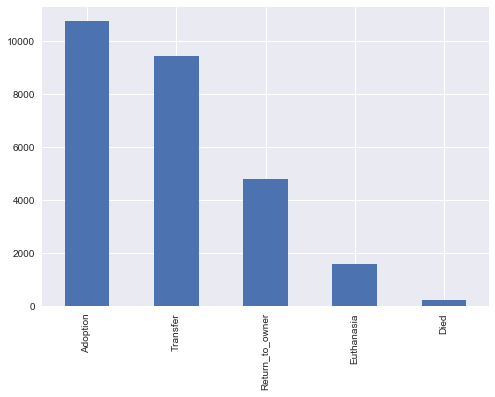

In [5]:
tr_data.OutcomeType.value_counts().plot(kind = 'bar')

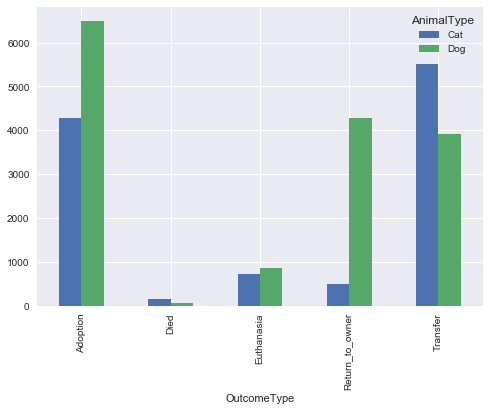

In [6]:
# let's try to split the aggragated classes by different features - well start with the animal type:
tr_data.pivot_table(columns='AnimalType',index = 'OutcomeType', values='DateTime', aggfunc=np.count_nonzero).plot(kind = 'bar')

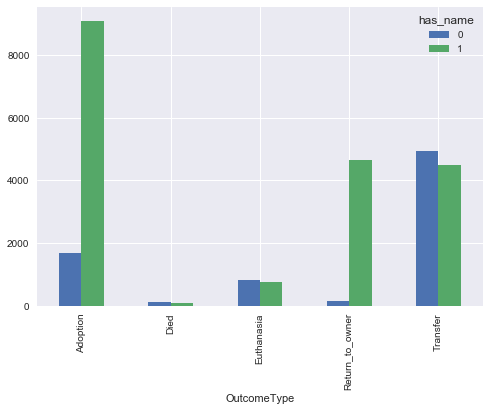

In [7]:
tr_data['has_name'] = 1-tr_data.Name.isnull()*1

tr_data.pivot_table(columns='has_name',index = 'OutcomeType', values='DateTime', aggfunc=np.count_nonzero).plot(kind = 'bar')
tr_data.drop(['has_name'],axis=1,inplace=True)

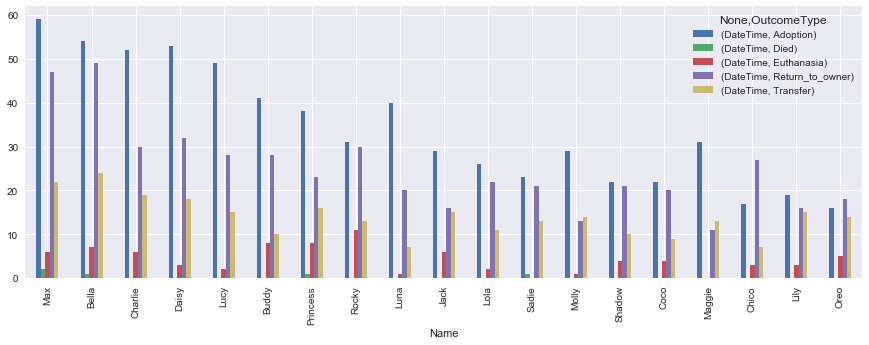

In [8]:
# so we learned that pets with names are more likely to be returned to their owner (makes sense)
# and also more likely to be adopted (sympathy?)
# lets try to dig a bit dipper to this feature

# let's create a pivot table that presents the counts of each name for each category 
names_pivot = tr_data.pivot_table(index=['Name'],columns=['OutcomeType'],values=['DateTime'], 
                    aggfunc=np.count_nonzero,fill_value=0, margins = True)

# now let's sort our pivot table so that the most common names will show first
names_pivot = names_pivot.sort_values(ascending = False,by=('DateTime','All'))

# lets view the first 20 , don't forget to set the plot area (using the figsize parameter)
names_pivot.iloc[1:20,:-1].plot(kind = 'bar',figsize=(15,5))

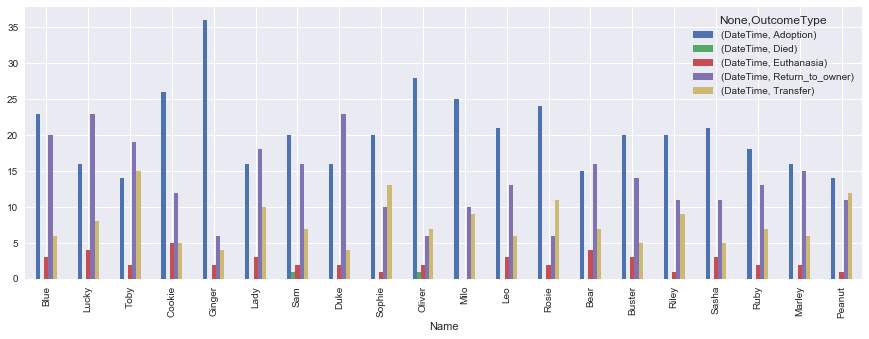

In [9]:
names_pivot.iloc[20:40,:-1].plot(kind = 'bar',figsize=(15,5))

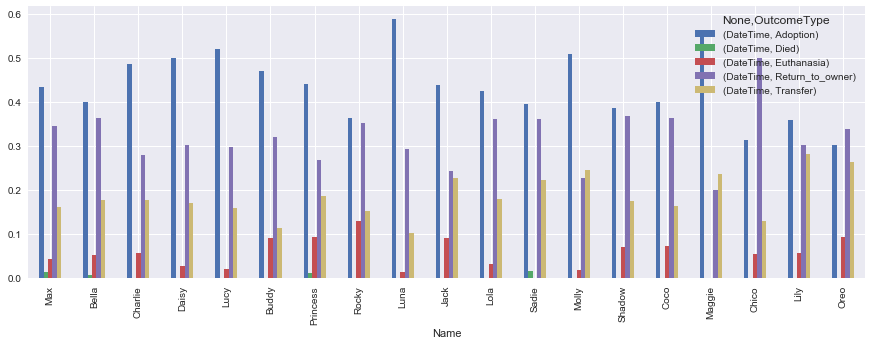

In [10]:
# as one of the students comented in the previous lesson, 
# sometimes its better to explore frequencies rather than explore the counts themselves

def piv2pcnt(pivoted):
    # this is a helper function to convert a pivot table of counted shows to frequencies
    # assumptions: the input is a pivot table with margins = true & the last column contains the sum of counts
    return pivoted.div(pivoted.iloc[:,-1],axis = 0)

piv2pcnt(names_pivot).iloc[1:20,:-1].plot(kind = 'bar',figsize=(15,5))

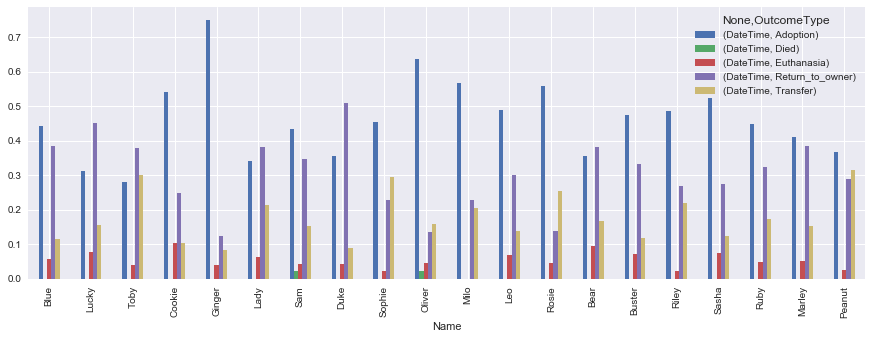

In [11]:
# now do the same for the next 20:
piv2pcnt(names_pivot).iloc[20:40,:-1].plot(kind = 'bar',figsize=(15,5))

#### you are welcome to try and explore some more interesting ratios from the train data

let me know about your findings!

## data pre-processing 

This is where the fun starts :-)
#### "our model is only as good as the features that we supply it with"
* pre-process dates - extract numerical feautres such as time of day, month, weekday etc. 
* pre-process names and other character features (remove sparse names, remove capitalization, correct spelling)

In [12]:
# a good practice is to apply all transformations on the concatination of train and test data
# so we'll first set appart the target and other features in which we can't use for the modeling stage
# and then concatinate the train and test data

In [13]:
target = tr_data.OutcomeType
train_ids,test_ids = tr_data.AnimalID , te_data.ID
tr_data.drop(['OutcomeType','OutcomeSubtype','AnimalID'],axis=1,inplace=True)
te_data.drop(['ID'],axis=1,inplace=True)
full_data = pd.concat([tr_data,te_data],axis=0)

In [14]:
def extract_date_features(date_column):
    temp = pd.to_datetime(date_column)
    return pd.DataFrame({"year": temp.dt.year,
                         "month": temp.dt.month,
                         "dayofyear": temp.dt.dayofyear,
                         "weekofyear": temp.dt.weekofyear,
                         "dayofweek": temp.dt.dayofweek,
                         "hour": temp.dt.hour
                        })

In [15]:
full_data = pd.concat([full_data,extract_date_features(full_data['DateTime'])],axis=1)
full_data.drop(['DateTime'],axis=1,inplace=True)

# now let's look at the new features we created
full_data.iloc[:,-5:].head()

,dayofyear,hour,month,weekofyear,year
0,43,18,2,7,2014
1,286,12,10,41,2013
2,31,12,1,5,2015
3,192,19,7,28,2014
4,319,12,11,46,2013


## what could be wrong with the age feature?
* its textual rather than numerical, but thats not all...
* UOM are different

In [16]:
full_data.AgeuponOutcome.value_counts()[:10]

1 year      5737
2 years     5383
2 months    4929
3 years     2589
3 months    1788
1 month     1782
4 years     1506
5 years     1406
4 months    1283
3 weeks      950
Name: AgeuponOutcome, dtype: int64

In [17]:
# before parsing the text (especially when using the apply function) 
# we need to verify that all the text feature has values to prevent an error while running
full_data.AgeuponOutcome.fillna('1 unknown',inplace=True)

#now we can split the data to quantity and type of time specified
temp = pd.DataFrame([(float(x.split(' ')[0]),x.split(' ')[1]) for x in full_data.AgeuponOutcome])
temp.columns = ['quan','timetype']

In [18]:
#now lets explore the unique values that the type of time feature contains
temp['timetype'].unique()

array(['year', 'years', 'weeks', 'month', 'months', 'days', 'week', 'day',
       'unknown'], dtype=object)

In [19]:
# since we want to generalize let's convert single form to plural
temp['timetype'].replace(['year','month','week', 'day' ],[ 'years', 'months', 'weeks',  'days'],inplace = True)

In [20]:
# now we can convert the feature values to run on a single scale  
def unify_age_scale(row):
    timetype = row.timetype
    quan = row.quan
    if timetype=='years':
        return quan*12.0
    elif timetype=='weeks':
        return quan/4.2
    elif timetype=='days':
        return quan/30.0
    elif timetype=='unknown':
        return -999.0
    else:
        return quan
    
temp = temp.apply(unify_age_scale,axis = 1)

full_data['rescaled_AgeuponOutcome'] = temp
full_data.drop(['AgeuponOutcome'],axis=1,inplace=True)

In [21]:
# we can now convert some more of the textual features with less varience to numeric representation:
full_data.AnimalType = full_data.AnimalType.replace(['Dog','Cat'],[0,1])

In [22]:
full_data.SexuponOutcome.fillna(value='unknown unknown',inplace=True)
full_data.SexuponOutcome.replace(['Unknown'],['unknown unknown'],inplace=True)

In [23]:
temp = pd.DataFrame([x.split(' ') for x in full_data.SexuponOutcome])
temp.columns = ['status','sex']
print ('the unique values fot status are: {}'.format(temp.status.unique()))
print ('the unique values fot sex are: {}'.format(temp.sex.unique()))

the unique values fot status are: ['Neutered' 'Spayed' 'Intact' 'unknown']
the unique values fot sex are: ['Male' 'Female' 'unknown']


In [24]:
# let's replace these values to numeric as well:
# * it's a good practice to use extreme value for unknown we'll usually be using -999 or -9999
temp.status.replace(['Neutered', 'Spayed', 'Intact', 'unknown'],[0,1,2,-999],inplace=True)
temp.sex.replace(['Male', 'Female', 'unknown'],[0,1,-999],inplace=True)

In [25]:
full_data['sex'] = temp.sex
full_data['status'] = temp.status
full_data.drop(['SexuponOutcome'],axis=1,inplace=True)

In [26]:
full_data.Breed.value_counts()[30:65]

Staffordshire Mix                     135
American Staffordshire Terrier Mix    129
Pointer Mix                           128
Chihuahua Shorthair                   125
Labrador Retriever                    110
Labrador Retriever/Pit Bull           108
Plott Hound Mix                       108
Snowshoe Mix                          105
Dachshund/Chihuahua Shorthair         104
Pit Bull                              101
Black Mouth Cur Mix                    98
Miniature Pinscher Mix                 98
Anatol Shepherd Mix                    97
German Shepherd                        95
German Shepherd/Labrador Retriever     95
American Pit Bull Terrier Mix          94
Golden Retriever Mix                   88
Labrador Retriever/German Shepherd     81
Chow Chow Mix                          76
Shih Tzu                               75
Queensland Heeler Mix                  75
Cardigan Welsh Corgi Mix               72
Maltese Mix                            71
Dachshund                         

In [27]:
# only needed if not already installed 
#!pip install wordcloud 
## '!' mark within a notebook cell runs a shell command within the cell

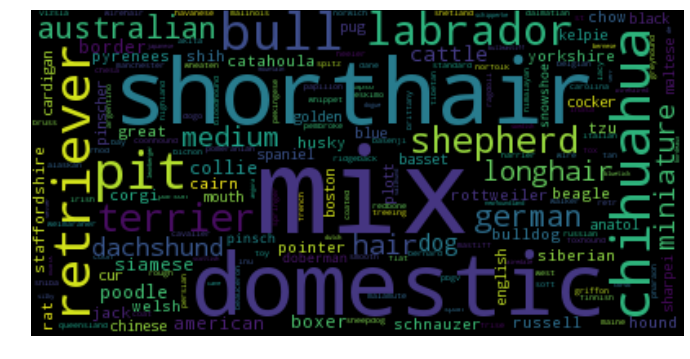

In [28]:
from wordcloud import WordCloud
text = full_data.Breed.str.cat(sep = ' ')
wc = WordCloud(collocations=False).generate(text.lower())
plt.figure(figsize=(15,6))
#plt.subplot2grid(2,1)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [29]:
#list(wc.words_.keys())
#pd.DataFrame({'words':list(wc.words_.keys()),'frequency':list(wc.words_.items())})
frequency_df = pd.DataFrame(list(wc.words_.items()))
frequency_df.columns = ['word','frequency']
frequency_df.sort_values('frequency',ascending=False)[:10]

,word,frequency
0,mix,1.000000
1,shorthair,0.511123
2,domestic,0.466788
3,chihuahua,0.115779
4,retriever,0.111041
5,bull,0.110728
6,pit,0.108500
7,labrador,0.102915
8,terrier,0.076402
9,shepherd,0.062784


##### check for common symilarities rather than exact same - this helps to prevent overfitting
lets create some features from what we can see in the word cloud:

* has "mix"
* has "shorthair"
* has "domestic"
* has "chihuahua"
* has "retriever"
* etc.


* notice we used x.lower() function that we learned about in our last lecture to unify the different spelling with same meaning

In [30]:
num_breed_features = 30
for i,w in enumerate(frequency_df.word[:num_breed_features]):
    full_data['has_{}_inBreed'.format(w)] = full_data.Breed.apply(lambda x: (w in x.lower())*1)

# once we extracted all of the features we can remove the breed original feature
full_data.drop(['Breed'],axis=1,inplace=True)

In [31]:
# now try to do the same with the color feature
text = full_data.Color.str.cat(sep = ' ')
wc = WordCloud(collocations=False).generate(text.lower())
num_color_features = 30
for i,w in enumerate(frequency_df.word[:num_color_features]):
    full_data['has_{}_inColor'.format(w)] = full_data.Color.apply(lambda x: (w in x.lower())*1)

# once we extracted all of the features we can remove the breed original feature
full_data.drop(['Color'],axis=1,inplace=True)

In [32]:
full_data.head(8)

,Name,AnimalType,dayofweek,dayofyear,hour,month,weekofyear,year,rescaled_AgeuponOutcome,sex,status,has_mix_inBreed,has_shorthair_inBreed,has_domestic_inBreed,has_chihuahua_inBreed,has_retriever_inBreed,has_bull_inBreed,has_pit_inBreed,has_labrador_inBreed,has_terrier_inBreed,has_shepherd_inBreed,has_australian_inBreed,has_german_inBreed,has_hair_inBreed,has_medium_inBreed,has_longhair_inBreed,has_miniature_inBreed,has_dachshund_inBreed,has_dog_inBreed,has_cattle_inBreed,has_poodle_inBreed,has_border_inBreed,has_collie_inBreed,has_siamese_inBreed,has_boxer_inBreed,has_american_inBreed,has_hound_inBreed,has_beagle_inBreed,has_russell_inBreed,has_schnauzer_inBreed,has_chow_inBreed,has_mix_inColor,has_shorthair_inColor,has_domestic_inColor,has_chihuahua_inColor,has_retriever_inColor,has_bull_inColor,has_pit_inColor,has_labrador_inColor,has_terrier_inColor,has_shepherd_inColor,has_australian_inColor,has_german_inColor,has_hair_inColor,has_medium_inColor,has_longhair_inColor,has_miniature_inColor,has_dachshund_inColor,has_dog_inColor,has_cattle_inColor,has_poodle_inColor,has_border_inColor,has_collie_inColor,has_siamese_inColor,has_boxer_inColor,has_american_inColor,has_hound_inColor,has_beagle_inColor,has_russell_inColor,has_schnauzer_inColor,has_chow_inColor
0,Hambone,0,2,43,18,2,7,2014,12.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Emily,1,6,286,12,10,41,2013,12.000000,1,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Pearce,0,5,31,12,1,5,2015,24.000000,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NaN,1,4,192,19,7,28,2014,0.714286,0,2,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NaN,0,4,319,12,11,46,2013,24.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Elsa,0,4,115,13,4,17,2014,1.000000,1,2,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Jimmy,1,5,87,13,3,13,2015,0.714286,0,2,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,NaN,1,3,120,17,4,18,2015,0.714286,-999,-999,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
full_data['has_name'] = full_data.Name.isnull()*1
full_data.drop(['Name'],axis=1,inplace=True)

In [34]:
# once we're done with preprocessing we can separate the train and test again
tr_processed_data = full_data[:26729]
te_processed_data = full_data[26729:]
tr_processed_data.shape

(26729, 71)

In [35]:
target.replace(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'],[0,1,2,3,4],inplace=True)

In [40]:
from sklearn.grid_search import GridSearchCV
gbc = GradientBoostingClassifier()
gbc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [38]:
%%time
random.seed(1234)
gbc = GradientBoostingClassifier(max_depth=6,n_estimators=30,subsample=0.6,random_state=1234)
X_train,X_val,y_train,y_val = train_test_split(tr_processed_data,target,test_size=0.3, random_state=1234)#,stratify=True)
gbc.fit(X_train,y_train)
pred = gbc.predict(X_val)
print(classification_report(y_pred=pred,y_true=y_val))
pred_proba = gbc.predict_proba(X_val)
print('log_loss: {}'.format(log_loss(y_pred=pred_proba,y_true=y_val)))

             precision    recall  f1-score   support

          0       0.50      0.48      0.49      1439
          1       0.61      0.20      0.30       507
          2       0.70      0.84      0.76      3216
          3       0.76      0.70      0.73      2806
          4       0.50      0.10      0.16        51

avg / total       0.68      0.68      0.67      8019

log_loss: 0.7834798673347545
Wall time: 17.7 s


In [ ]:
%%time

tune_grid = {'subsample':[0.3,0.5,0.7,0.9],'n_estimators':[10,30],'max_depth':[3,5]}

score = 'neg_log_loss'
print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(GradientBoostingClassifier(max_depth=3), tune_grid, cv=5, scoring='%s' % score,n_jobs=4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

In [ ]:
%%time
from sklearn.grid_search import GridSearchCV
tune_grid = {'subsample':[0.3,0.5,0.7,0.9],'n_estimators':[10,30],'max_depth':[7,9]}

score = 'neg_log_loss'
print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(GradientBoostingClassifier(max_depth=7), tune_grid, cv=5, scoring='%s' % score,n_jobs=4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

In [ ]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=4)
tune_grid = {'leaf_size':[10,30,100],'n_neighbors':[3,5,10,30],'p':[1.5,2]}
score = 'neg_log_loss'
print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(KNeighborsClassifier(n_jobs=4), tune_grid, cv=5, scoring='%s' % score,n_jobs=4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

In [41]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=4)
tune_grid = {'leaf_size':[30],'n_neighbors':[250,500,1000],'p':[0.8,1.1]}
score = 'neg_log_loss'
print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(KNeighborsClassifier(n_jobs=4), tune_grid, cv=5, scoring='%s' % score,n_jobs=4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

# Tuning hyper-parameters for neg_log_loss

Best parameters set found on development set:
{'leaf_size': 30, 'n_neighbors': 250, 'p': 1.3}
Grid scores on development set:
-1.326 (+/--0.029) for {'leaf_size': 30, 'n_neighbors': 40, 'p': 1.3}
-1.358 (+/--0.028) for {'leaf_size': 30, 'n_neighbors': 40, 'p': 1.5}
-1.224 (+/--0.031) for {'leaf_size': 30, 'n_neighbors': 60, 'p': 1.3}
-1.240 (+/--0.024) for {'leaf_size': 30, 'n_neighbors': 60, 'p': 1.5}
-1.183 (+/--0.021) for {'leaf_size': 30, 'n_neighbors': 80, 'p': 1.3}
-1.195 (+/--0.028) for {'leaf_size': 30, 'n_neighbors': 80, 'p': 1.5}
-1.150 (+/--0.027) for {'leaf_size': 30, 'n_neighbors': 100, 'p': 1.3}
-1.162 (+/--0.028) for {'leaf_size': 30, 'n_neighbors': 100, 'p': 1.5}
-1.096 (+/--0.005) for {'leaf_size': 30, 'n_neighbors': 250, 'p': 1.3}
-1.104 (+/--0.006) for {'leaf_size': 30, 'n_neighbors': 250, 'p': 1.5}
Wall time: 3min 24s


In [43]:
%%time
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_jobs=4)
tune_grid = {'leaf_size':[30],'n_neighbors':[250,500,1000],'p':[1.01,1.1]}
score = 'neg_log_loss'
print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(KNeighborsClassifier(n_jobs=4), tune_grid, cv=5, scoring='%s' % score,n_jobs=4)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print(clf.best_params_)
print("Grid scores on development set:")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r"
          % (mean_score, scores.std() * -1, params))

# Tuning hyper-parameters for neg_log_loss

Best parameters set found on development set:
{'leaf_size': 30, 'n_neighbors': 250, 'p': 1.01}
Grid scores on development set:
-1.074 (+/--0.003) for {'leaf_size': 30, 'n_neighbors': 250, 'p': 1.01}
-1.079 (+/--0.003) for {'leaf_size': 30, 'n_neighbors': 250, 'p': 1.1}
-1.084 (+/--0.008) for {'leaf_size': 30, 'n_neighbors': 500, 'p': 1.01}
-1.089 (+/--0.006) for {'leaf_size': 30, 'n_neighbors': 500, 'p': 1.1}
-1.111 (+/--0.006) for {'leaf_size': 30, 'n_neighbors': 1000, 'p': 1.01}
-1.116 (+/--0.006) for {'leaf_size': 30, 'n_neighbors': 1000, 'p': 1.1}
Wall time: 4min 43s
